![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
from datetime import datetime as dt

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import statistics

# Any results you write to the current directory are saved as output.

In [116]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [117]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Functions



In [118]:
# function which find duplicated values in column (1-has dupl, 0-doesn't have)
def dup_col(col):
        duplicated_col = col.value_counts().loc[lambda x: x > 1].index.tolist()
        new_col = []
        for x in col:
            if x in duplicated_col:
                new_col.append(1)
            else:
                new_col.append(0)
        return new_col

In [119]:
#функция расчета интервала между отзывами
def find_days(d):
    ln_d = len(d)
    if len(d) >1:
        return (d[0]-d[1]).days
        

In [120]:
def key_words(df,col,rating,number):
    vc = df[df[col]==rating]
    f = vc.Reviews.apply(lambda x:  np.nan if pd.isna(x) else str(x).strip(
    '[] ][').replace("'", "").replace("[", "").replace(']', '').lower())
    pat = re.compile('^[A-Za-z]+\s[A-Za-z]+')
    return  f.apply(lambda x:  re.findall(pat, x)).explode().value_counts()[:number].index


In [327]:
#стандартизация признака
def stand(col):
    std =np.std(col)
    mean=(col).mean()
    return (col-mean)/std

# DATA

In [121]:
'''DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')'''

"DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'\ndf_train = pd.read_csv(DATA_DIR+'/main_task.csv')\ndf_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')\nsample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')"

In [122]:

df_train = pd.read_csv('main_task_new.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [124]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [125]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [126]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [127]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [128]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [129]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [131]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
27201,id_2042,Warsaw,['Middle Eastern'],2044.0,$$ - $$$,11.0,"[['Work evening.', 'A chillout sheesha place']...",/Restaurant_Review-g274856-d7378360-Reviews-Kl...,d7378360,1,4.0
19575,id_3094,Lisbon,"['Bar', 'Pub', 'American']",3097.0,$,59.0,"[['Slow!', 'Nice'], ['08/05/2017', '09/27/2015']]",/Restaurant_Review-g189158-d1972408-Reviews-Li...,d1972408,1,3.5
16545,id_2350,Prague,"['Bar', 'Pub', 'Czech', 'European', 'Central E...",2355.0,$,52.0,"[['Cheep and cheerful.', 'Stay at Cettia Beach...",/Restaurant_Review-g274707-d4915056-Reviews-Re...,d4915056,1,4.0
49088,id_4284,Milan,['Italian'],4287.0,$$$$,20.0,"[['Recommended during week-days'], ['11/28/201...",/Restaurant_Review-g187849-d2016165-Reviews-Tr...,d2016165,1,3.5
22942,id_2820,Lisbon,"['Chinese', 'Japanese', 'Sushi']",2823.0,NaN,7.0,"[['Chinese cusine', 'A pleasant dinner with mo...",/Restaurant_Review-g189158-d6451020-Reviews-Bo...,d6451020,1,3.5


In [132]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [133]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [134]:
data['Number_of_Reviews_isNAN'].value_counts()

0    46800
1     3200
Name: Number_of_Reviews_isNAN, dtype: int64

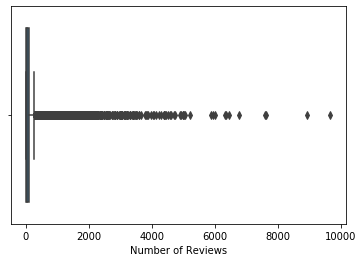

In [135]:
# посмотрим на выбросы
sns.boxplot(data['Number of Reviews'])

In [136]:
# значения больше 5000 это выбросы, поэтому все что выше 5000 приравняем к 5000

data['Number of Reviews'] = data['Number of Reviews'].apply(lambda x: 5000 if x > 5000 else x)

In [137]:
# Далее заполняем пропуски  средним по городу и тд...
data["Number of Reviews"] = data.groupby("City")['Number of Reviews']\
    .transform(lambda x: x.fillna(round(x.mean())))

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [138]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1560
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [139]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0


In [140]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN
45811,id_5331,Milan,"['Italian', 'Mediterranean']",5334.0,$$ - $$$,28.0,"[['Great location, nice little restaurant.', '...",/Restaurant_Review-g187849-d4581808-Reviews-Ca...,d4581808,1,3.5,0
16828,id_4175,Madrid,"['Bar', 'Pub']",4177.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187514-d4436466-Reviews-Ja...,d4436466,1,5.0,0
18566,id_13955,London,NaN,13965.0,NaN,24.0,"[['Home made burrata', 'Appalling service and ...",/Restaurant_Review-g186338-d4106385-Reviews-Mo...,d4106385,1,3.5,0
39870,id_6843,London,"['American', 'Steakhouse', 'Grill', 'Halal', '...",6852.0,$$ - $$$,26.0,"[['AMAZING', 'Awesome food + environment'], ['...",/Restaurant_Review-g186338-d12622101-Reviews-G...,d12622101,1,4.5,0
5231,id_5231,Rome,['Italian'],3709.0,$$ - $$$,12.0,"[['Best dinner experience in Rome', 'Amazing f...",/Restaurant_Review-g187791-d11752076-Reviews-F...,d11752076,0,0.0,0


#### Возьмем следующий признак "Price Range".

In [141]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [142]:
# Ваша обработка 'Price Range'
data['New_Price_Range'] = data['Price Range'].map({'$$ - $$$':2, '$':1, '$$$$':3})

In [143]:
data['New_Price_Range'].value_counts()

2.0    23041
1.0     7816
3.0     1782
Name: New_Price_Range, dtype: int64

In [144]:
#Далее заполняем пропуски  средним по городу и тд...
data['New_Price_Range'] = data.groupby("City")['New_Price_Range']\
                            .transform(lambda x: x.fillna(round(x.mean()))).astype('uint8')

In [145]:
# вынести информацию о наличии пропуска как отдельный признак
data['Price_Range_nan'] = pd.isna(data['Price Range']).astype('uint8')

In [146]:
data['Price Range'].isna().astype(int).sum()

17361

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [147]:
# 
# .....

Cuisine Style

In [148]:
#упростим данные о кухне
data['Cuisine Style'] = data['Cuisine Style']\
                        .apply(lambda x:  np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", "))


In [149]:
data['Cuisine Style'][:2]

0                                           [Bar, Pub]
1    [European, Scandinavian, Gluten Free Options, ...
Name: Cuisine Style, dtype: object

In [150]:
# сортировка по популярности
data['Cuisine Style'].explode().value_counts(ascending=False)[:10]

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Name: Cuisine Style, dtype: int64

In [151]:
#найдем список 3  наиболее часто встречающихся кухонь
cuisine_3mode=data['Cuisine Style'].explode().value_counts(ascending=False)[:3].index.tolist()


(cuisine_3mode)

['Vegetarian Friendly', 'European', 'Mediterranean']

In [152]:
#Cоздадим столбцы - 3 наиболее часто встречающихся кухонь и все остальные
for i in cuisine_3mode:
    data[i] = data['Cuisine Style'].apply(lambda x: 1 if type(x)!= float and   i in x    else 0)
    

data['Cuisine_other'] = data['Cuisine Style'].apply(lambda x: 1 if type(x)!=float and  all([cuis not in cuisine_3mode for cuis in x]) else 0)

In [154]:
# столбец с подсчетом кухонь в ресторане
data['Cuisine_Style_number'] = data['Cuisine Style']\
                                .apply(lambda x: 1 if type(x)==float and pd.isna(x)  else len(x))

ID_TA

In [156]:
# create id_ta without d
data['ID_TA_n'] = data.ID_TA.apply(lambda x: x[1:]).astype(str).astype(int)
# create column with id_ta which has duplicates 
data['ID_TA_dup'] = dup_col(data.ID_TA)



Reviews¶

In [157]:
# создадим столбец с датами


In [225]:
pat = re.compile('\d{2}\/\d{2}\/\d{4}')
data['Review_date'] = data.Reviews\
                    .apply(lambda x: [] if pd.isna(x) else re.findall(pat,x) )\
                    .apply(lambda y:[pd.to_datetime(item) for item in y ])

In [226]:
# создаем столбец - разница дат отзывов
data['Review_date_dif'] = data.Review_date.apply(lambda x: find_days(x))

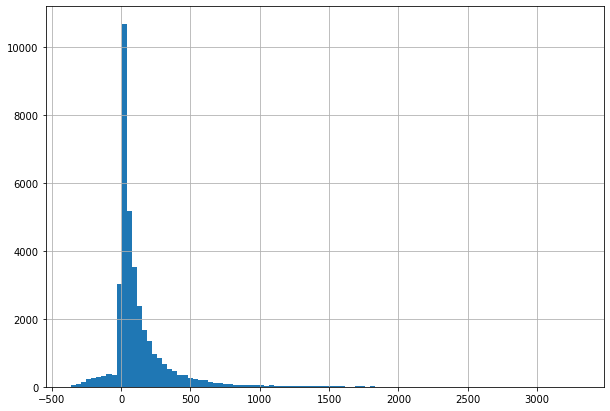

In [227]:
data['Review_date_dif'].hist(bins=100)

In [228]:
#заполним пробелы  средним
data['Review_date_dif'].fillna(round(data['Review_date_dif'].mean()), inplace=True)

In [235]:
data['Review_date_dif'].isna().sum()

0

In [314]:
# create column with last review date & the latest review at all difference
data['last_rev_date'] = data.Review_date.apply(lambda x: np.nan if not x else max(x))
md = max(data['last_rev_date'].dropna())
data['last_rev_date'] = data['last_rev_date'].apply(lambda x: (md-x).days)

In [315]:
# заполним пробелы средним
# 
data['last_rev_date'].fillna(round(data['last_rev_date'].mean()), inplace=True)

In [316]:
# нормализуем  last_rev_date  через логарифмирование 
data['last_rev_date'] = np.log2(data['last_rev_date']+1)
#data['last_rev_date'] = stand(data['last_rev_date'])

In [265]:

'''std =np.std(data['Review_date_dif'])
mean=(data['Review_date_dif']).mean()
data['st_Review_date_dif']= data['Review_date_dif'].apply(lambda x: (x-mean)/std)'''

In [328]:
# стандартизируем Review_date_dif
data['st_Review_date_dif'] = stand(data['Review_date_dif'])

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

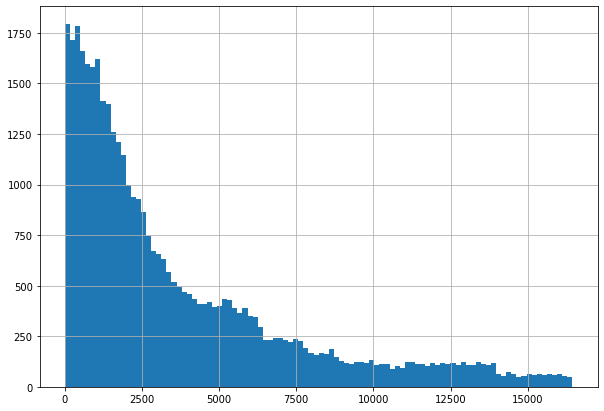

In [168]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

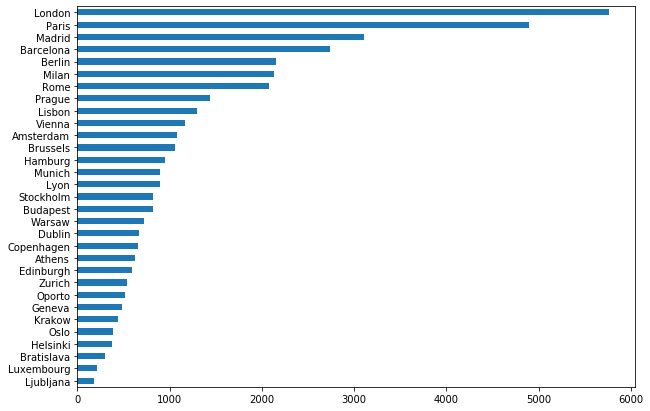

In [169]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

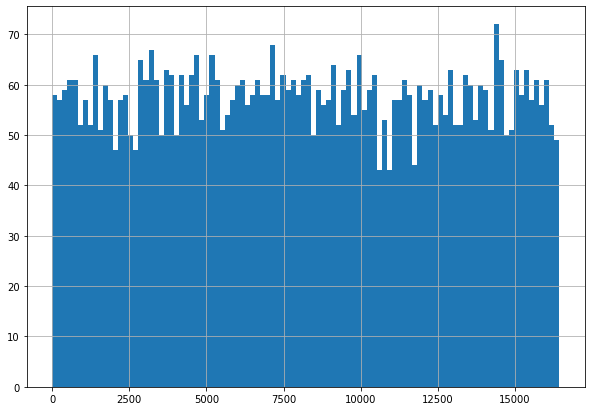

In [170]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

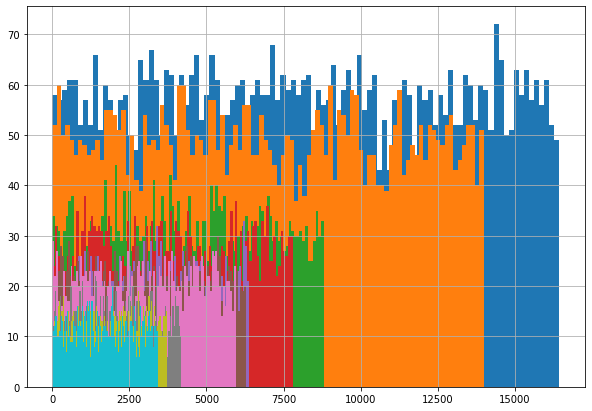

In [171]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.



In [172]:
# создадим стобец о количестве ресторанов по городам
data['rest_in_city'] = data.groupby('City')['Restaurant_id'].transform('count')

,Ranking,rest_in_city,Number of Reviews
Ranking,1.000000,0.709012,-0.218362
rest_in_city,0.709012,1.000000,0.027209
Number of Reviews,-0.218362,0.027209,1.000000


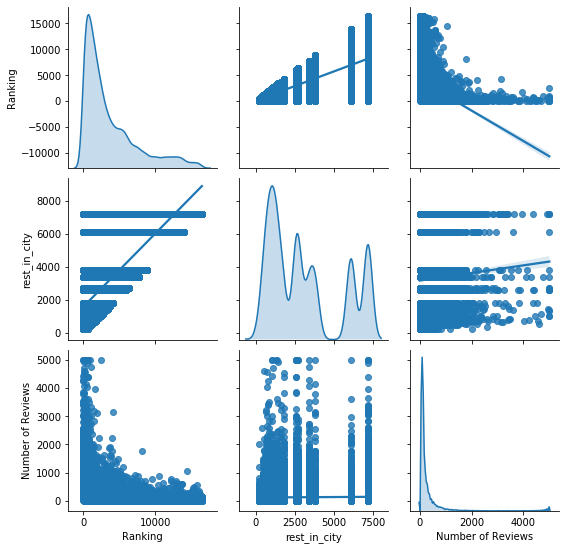

In [173]:
#посмотрим взаимосвязь
display(data[["Ranking","rest_in_city","Number of Reviews"]].corr())
sns.pairplot(data, vars = ["Ranking","rest_in_city","Number of Reviews"], kind = 'reg',diag_kind="kde")

In [174]:
#столбец polynomial features
data['polin2']= data['Ranking']*data['Number of Reviews']


In [175]:
#нормализуем
data["polin2_log"] = np.log2(data["polin2"])

In [176]:
# нормализация количества ресторанов в городе и рангов
data['n_rest'] = data['rest_in_city']/data['Ranking']
data['n_rank'] = data['Ranking']/data['rest_in_city']


In [177]:
# находим место ресторана в ренкинге ресторанов данного города (нормализация)
data['Ranking_max_norm'] = data['Ranking'] / data['City'].map(data.groupby(['City'])['Ranking'].max())

In [178]:
# столбец о количестве кухонь в городе
data['Cuisine_number_per_city'] = data.groupby('City')['Cuisine Style'].transform(lambda x: len(np.unique(np.hstack(x))))

### Посмотрим распределение целевой переменной

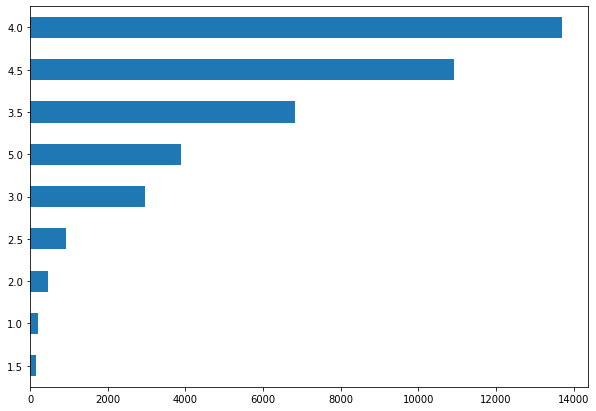

In [179]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

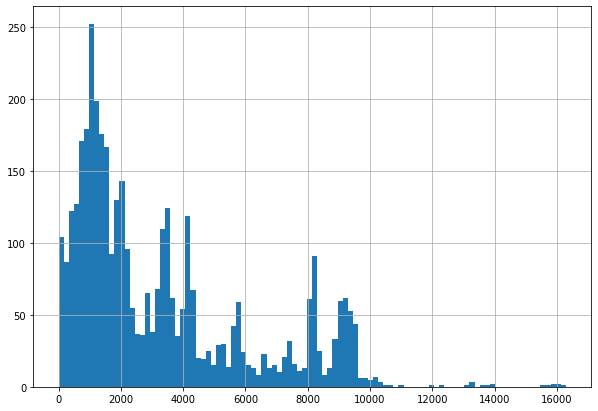

In [180]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

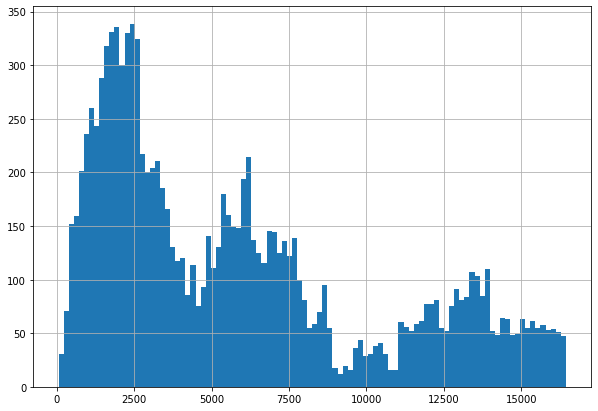

In [181]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [182]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City'])

In [183]:
key={}
for i in data.Rating.unique(): 
    if i!= 0:
        key[i] = key_words(data,'Rating',i,15)
print (key)       

{3.5: Index(['good food', 'very good', 'nice place', 'great food', 'good for',
       'great place', 'good value', 'very nice', 'a good', 'nice food',
       'one of', 'good place', 'excellent food', 'the best', 'good pizza'],
      dtype='object'), 4.0: Index(['good food', 'very good', 'great food', 'nice place', 'great place',
       'very nice', 'excellent food', 'nice food', 'the best', 'really good',
       'good value', 'good place', 'great for', 'delicious food', 'a great'],
      dtype='object'), 4.5: Index(['great food', 'very good', 'good food', 'great place', 'the best',
       'very nice', 'excellent food', 'nice place', 'amazing food', 'one of',
       'delicious food', 'a great', 'what a', 'hidden gem', 'great little'],
      dtype='object'), 5.0: Index(['the best', 'great food', 'excellent food', 'great place', 'very nice',
       'great little', 'one of', 'hidden gem', 'good food', 'nice place',
       'very good', 'delicious food', 'a great', 'great coffee',
       'am

In [ ]:
#ключевые слова не дали улучшения

In [279]:
# поскольку есть повторы  Restaurant_id  то используем dummy variable
data = pd.get_dummies(data, columns = ['Restaurant_id'])

In [317]:
work = data.copy()
work.drop(['Ranking', 'Number of Reviews', 'polin2'], axis = 1, inplace=True)
df_preproc = work.select_dtypes(include=np.number)
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 13146 entries, sample to Restaurant_id_id_9999
dtypes: float64(8), int32(1), int64(9), uint8(13128)
memory usage: 632.7 MB


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

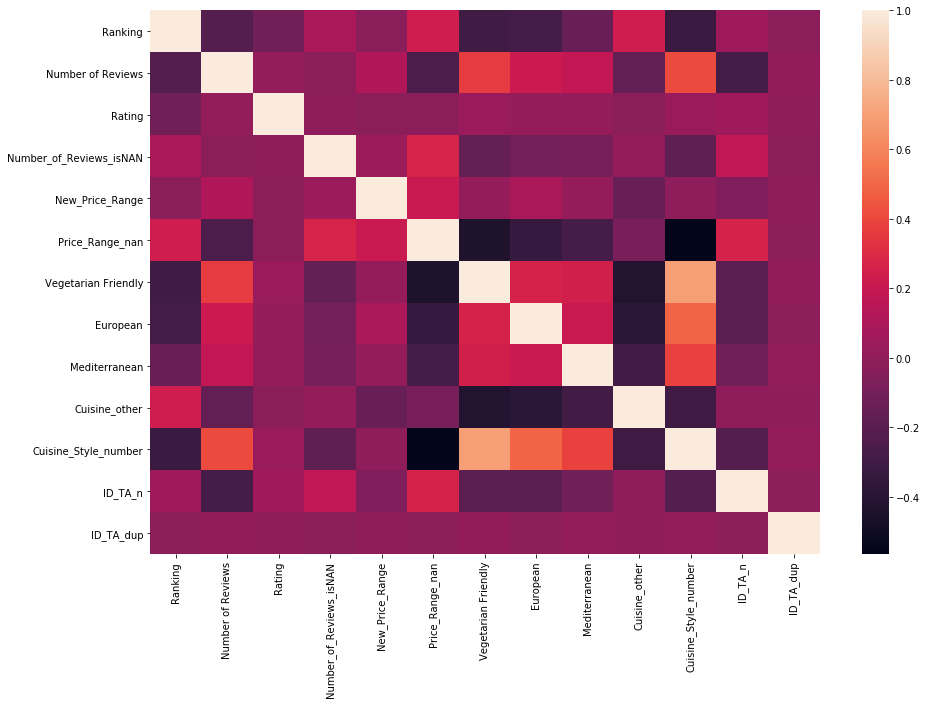

In [86]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).iloc[:,0:20].corr(),)

#### Запускаем и проверяем что получилось

In [108]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 13145 entries, sample to Restaurant_id_id_9999
dtypes: float64(7), int32(1), int64(9), uint8(13128)
memory usage: 632.3 MB


In [318]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [319]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [320]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 13145), (40000, 13145), (40000, 13144), (32000, 13144), (8000, 13144))

# Model 
Сам ML

In [321]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [322]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [323]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [324]:
# уберем ошибки из-за шага рейтинга 0,5
y_pred = (y_pred * 2).round()/2

In [325]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1563125


In [ ]:
MAE: 0.1563125

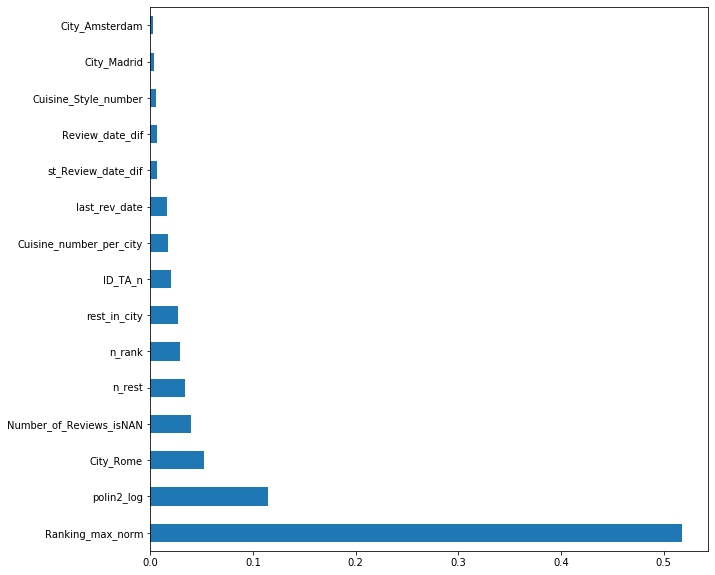

In [287]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [288]:
test_data.sample(10)

,Rating,Number_of_Reviews_isNAN,New_Price_Range,Price_Range_nan,Vegetarian Friendly,European,Mediterranean,Cuisine_other,Cuisine_Style_number,ID_TA_n,...,Restaurant_id_id_9990,Restaurant_id_id_9991,Restaurant_id_id_9992,Restaurant_id_id_9993,Restaurant_id_id_9994,Restaurant_id_id_9995,Restaurant_id_id_9996,Restaurant_id_id_9997,Restaurant_id_id_9998,Restaurant_id_id_9999
175,0.0,0,2,1,0,0,0,1,2,5223231,...,0,0,0,0,0,0,0,0,0,0
9950,0.0,0,2,1,0,0,0,0,1,8665422,...,0,0,0,0,0,0,0,0,0,0
5114,0.0,0,2,0,0,0,0,1,2,3488507,...,0,0,0,0,0,0,0,0,0,0
7685,0.0,0,2,0,0,0,0,1,1,7158442,...,0,0,0,0,0,0,0,0,0,0
5977,0.0,0,1,0,0,0,0,1,1,2002411,...,0,0,0,0,0,0,0,0,0,0
1249,0.0,0,2,0,1,0,1,0,7,1439850,...,0,0,0,0,0,0,0,0,0,0
5929,0.0,0,2,1,0,0,0,0,1,8281024,...,0,0,0,0,0,0,0,0,0,0
3181,0.0,0,2,1,0,0,0,0,1,8379570,...,0,0,0,0,0,0,0,0,0,0
1838,0.0,0,1,0,0,1,1,0,3,4339313,...,0,0,0,0,0,0,0,0,0,0
1734,0.0,0,2,0,0,0,0,1,2,12397070,...,0,0,0,0,0,0,0,0,0,0


In [289]:
test_data = test_data.drop(['Rating'], axis=1)

In [290]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [291]:
predict_submission = model.predict(test_data)
predict_submission = (predict_submission * 2).round()/2

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [292]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [293]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# Conclusions:
* Очень хорошая практика python & Pandas
* Практика  kaggle notebook
* Наибольший вклад внес feature признак нормализация ренкинга и перемножение  ренкинга с количеством отзывов
Таким образом данные о ренкинге оказались критически важными!
* 
В общем, процесс творческий и весьма увлекательный! 
